Data wrangling

# Problem statement
The goal for this project is to predict sales next calendar year for different Walmart stores based on two past year sales. With knowing the sales in the future, the management team will be able to provide guidance for supply chains to properly manage the inventory and allocate their resources, react to a market change, this help prevent unnecessary money loss. This can also be used to set sales target for sales department
success creterion: prediction accuracy rate is greater than 0.9
scope of solutions: ??
Sales can be reponsive to time factor(date, year, day, week, month, holiday) and space factor(store, dept, store type/size)

# 1. Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import os
from collections import Counter
from datetime import datetime

In [2]:
stores = pd.read_csv(r'C:/New folder/capstone 2/data/stores.csv')

In [3]:
features=pd.read_csv(r'C:/New folder/capstone 2/data/features.csv')

In [4]:
Weekly_sales=pd.read_csv(r'C:/New folder/capstone 2/data/train.csv')

In [5]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [6]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [7]:
Weekly_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


# 2. Exploring data

## 2.1 find missing values

In [8]:
Weekly_sales.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [9]:
features.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [10]:
features_missing = pd.concat([features.isnull().sum(), 100 * features.isnull().mean()],axis=1)
features_missing.columns=['count','%']
features_missing


,count,%
Store,0,0.000000
Date,0,0.000000
Temperature,0,0.000000
Fuel_Price,0,0.000000
MarkDown1,4158,50.769231
MarkDown2,5269,64.334554
MarkDown3,4577,55.885226
MarkDown4,4726,57.704518
MarkDown5,4140,50.549451
CPI,585,7.142857


In [11]:
stores.isnull().sum()

Store    0
Type     0
Size     0
dtype: int64

# 2.2 Categorical features-spacial factors(store,dept,store type,etc)


## 2.2.1 find duplicates 

In [12]:
#find duplicates in stores df
#find number of stores, make sure there is no duplicates
stores_count=stores['Store'].value_counts(sort=True)
print(stores_count.head())
#stores_count_dict=stores_count.to_dict
#print(k for k, v in stores_count_dict.items() if v>1)



1     1
24    1
26    1
27    1
28    1
Name: Store, dtype: int64


In [13]:
Weekly_sales['Store'].dtype


dtype('int64')

In [14]:
Weekly_sales['Dept'].dtype

dtype('int64')

In [15]:
Weekly_sales['Date'].dtype

dtype('O')

In [16]:
#(Weekly_sales['Store']) + ', ' +Weekly_sales['Dept'] + ', ' +Weekly_sales['Date']).value_counts(sort=True).head()

In [17]:
#find duplicates in Weekly_sales df based on selected columns
Weekly_sales[Weekly_sales.duplicated(subset=['Store','Dept','Date'], keep=False)]

,Store,Dept,Date,Weekly_Sales,IsHoliday


In [18]:
#find duplicates in features df based on selected columns
features[features.duplicated(subset=['Store','Date'], keep=False)]

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday


no duplicates found in all three datasets

## 2.2.2 "categorical" variables


even though store #, dept # are given in numbers, but they are considered as category features

In [19]:
Weekly_sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [20]:
#Use `select_dtypes` method to select columns of dtype 'object'
print(Weekly_sales.select_dtypes('object'))

              Date
0       2010-02-05
1       2010-02-12
2       2010-02-19
3       2010-02-26
4       2010-03-05
...            ...
421565  2012-09-28
421566  2012-10-05
421567  2012-10-12
421568  2012-10-19
421569  2012-10-26

[421570 rows x 1 columns]


this method is not applicable for the datasets!
the categorical features in three tables: stores-type, features-date, weekly_sales-department are not identified!!

#convert data type of int for col 'store' & 'Dept' to str
store_dept=['Store','Dept']
Weekly_sales[store_dept]=Weekly_sales[store_dept].astype(str)
#Weekly_sales['Store']=Weekly_sales['Store'].apply(str)
Weekly_sales


Weekly_sales_group_str=Weekly_sales.groupby(['Store','Dept']).size()

Weekly_sales_group_str=Weekly_sales_group_str.to_frame()

Weekly_sales_group_str




print(Weekly_sales.select_dtypes('object'))

features.head()

print(features.select_dtypes('object'))

features['Store']=features['Store'].apply(str)
features

stores.head()

stores['Store']=features['Store'].apply(str)
stores.head()

## 2.2.3 Identify types of stores 

In [21]:
# work on stores df
#count # of stores for each type
store_type=stores.groupby('Type').count()

type(store_type)

pandas.core.frame.DataFrame

In [22]:
store_type.drop(['Store'], axis=1,inplace=True)

store_type

,Size
Type,
A,22
B,17
C,6


In [23]:
#store_types=stores.Type.value_counts()
#store_types=store_types.to_frame()
#store_types=store_types.reset_index()
#store_types=store_types.rename(columns={'index':'type','Type':'counts'})
#print(store_types.columns)


In [24]:
#reset index for df and reame cols
store_type.reset_index(inplace=True)
store_type.rename(columns={'Size':'counts'},inplace=True)
store_type


,Type,counts
0,A,22
1,B,17
2,C,6


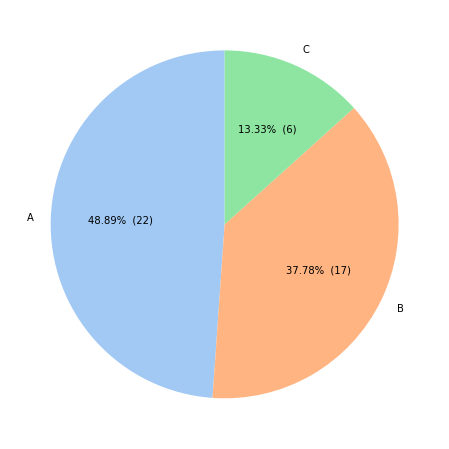

In [25]:
#plot pie chart for store type distribution with defined size
plt.figure(figsize=(10,8))

#define colors, refer to https://www.statology.org/seaborn-pie-chart/
colors = sns.color_palette('pastel')[0:3]  

label = store_type.Type
data = store_type.counts

#define function to plot both ratio and number for each store type
#https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct#:~:text=autopct%20enables%20you%20to%20display,set%20to%20the%20string%20'%25.
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.pie(data,labels=label,colors=colors,startangle = 90, autopct=make_autopct(data))
plt.show()

In [26]:
# find mean size of stores by different types
stores.groupby('Type',as_index=False)['Size'].mean()

,Type,Size
0,A,177247.727273
1,B,101190.705882
2,C,40541.666667


<AxesSubplot:xlabel='Type', ylabel='Size'>

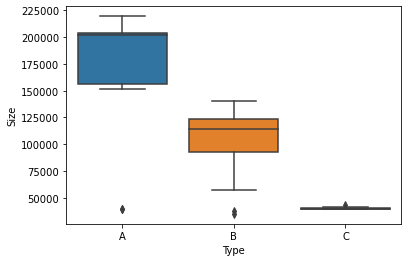

In [27]:
#plot boxplot of store size based on different store type
#sns.violinplot(x="Type", y="Size", data=stores); 
#https://hippocampus-garden.com/pandas_boxplot/

#stores.groupby('Type').boxplot(column='Size')

sns.boxplot(x="Type", y="Size", data=stores)


apparently, store type A has largest average size, store type C has smallest average size

## 2.2.4 record counts for each store and department

In [28]:
#group the record by 'store' and 'dept' for weekly_sales df
Weekly_sales_group=Weekly_sales.groupby(['Store','Dept']).size()
Weekly_sales_group=Weekly_sales_group.to_frame()
Weekly_sales_group.reset_index(inplace=True)
Weekly_sales_group.rename(columns={0:'counts'},inplace=True)
Weekly_sales_sort=Weekly_sales_group.sort_values('counts', ascending=False)
Weekly_sales_sort[(Weekly_sales_sort.counts==143) & (Weekly_sales_sort.Store==1)]

,Store,Dept,counts
0,1,1,143
1,1,2,143
21,1,23,143
23,1,25,143
24,1,26,143
...,...,...,...
54,1,67,143
55,1,71,143
56,1,72,143
57,1,74,143


In [29]:
#count records for each store
store_rec=Weekly_sales.Store.value_counts(sort=True)
store_rec=store_rec.to_frame()
store_rec.reset_index(inplace=True)
store_rec.rename(columns={'index':'store','Store':'count'},inplace=True)
store_rec.describe()



,store,count
count,45.000000,45.000000
mean,23.000000,9368.222222
std,13.133926,1215.026672
min,1.000000,6222.000000
25%,12.000000,9443.000000
50%,23.000000,9864.000000
75%,34.000000,10148.000000
max,45.000000,10474.000000


stores 1-45, store #13 has the most records, which is 10474, store #36 has least records, which is 6222

In [30]:
#count records for each dept
dept_rec=Weekly_sales.Dept.value_counts(sort=True)
dept_rec=dept_rec.to_frame()
dept_rec.reset_index(inplace=True)
dept_rec.rename(columns={'index':'dept','Dept':'count'},inplace=True)
dept_rec.describe()


,dept,count
count,81.000000,81.000000
mean,46.061728,5204.567901
std,29.388070,1896.081459
min,1.000000,12.000000
25%,22.000000,5297.000000
50%,42.000000,5956.000000
75%,72.000000,6435.000000
max,99.000000,6435.000000


total depts are 81, 22 depts have most of the records-6435: 1-4, 7,8,10,13,14,16,21,38,40,46,67,79,81,82,90-92,95, dept #43 has least # of records-12

In [31]:
#find the ones wih only one sales record
Weekly_sales_group[Weekly_sales_group['counts']==1]




,Store,Dept,counts
211,3,78,1
216,3,83,1
264,4,39,1
362,5,78,1
512,7,78,1
529,7,99,1
738,10,77,1
908,12,99,1
949,13,43,1
969,13,77,1


37 store-dept with only 1 sale record,  this may not be useful for sales prediction

<AxesSubplot:title={'center':'num of depts in each store'}, ylabel='Store'>

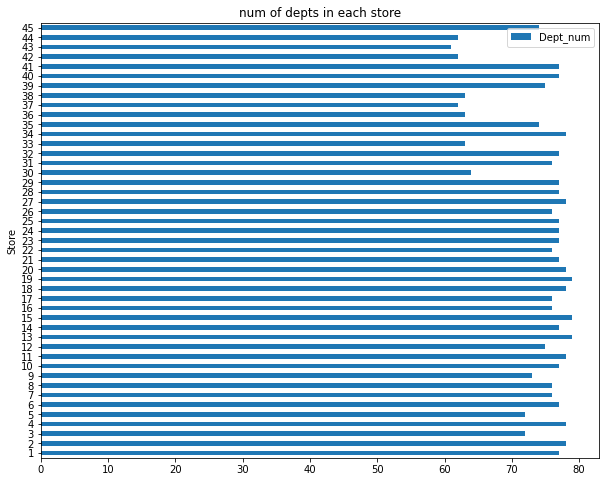

In [32]:
#find # of department in each store
Weekly_sales_dept_num=Weekly_sales_group.groupby('Store').count()
#Weekly_sales_dept_num.drop(columns=0, inplace=True)
#Weekly_sales_dept_num.reset_index(inplace=True)
Weekly_sales_dept_num.head()

Weekly_sales_dept_num = Weekly_sales_dept_num.rename(columns = {'Store':'Store','Dept':'Dept_num'})
Weekly_sales_dept_num.drop(['counts'], axis=1,inplace=True)
Weekly_sales_dept_num.head()
#x = Weekly_sales_dept_num.Store
#y = Weekly_sales_dept_num.Dept_num

#fig, ax = plt.subplots()
#ax.barh(x,y)
#plt.show()

Weekly_sales_dept_num.plot(kind='barh',title='num of depts in each store',figsize=(10,8))

Number of depts are relatively evenly distibuted among all the stores, #30,33, 36-38, 42-44 have less depts(~60) than the rest. majority stores have 72-80 depts

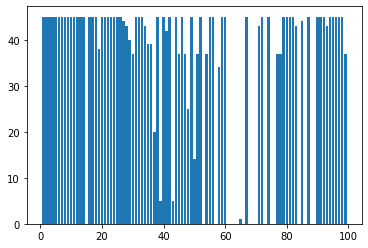

,Dept,store_num
57,65,1
41,43,5
37,39,5
48,50,14
35,37,20
46,48,25
54,58,34
80,99,37
43,45,37
49,51,37


In [33]:
#find out # of stores for each department 
Weekly_sales_store_num=Weekly_sales_group.groupby('Dept').count()


Weekly_sales_store_num.reset_index(inplace=True)

Weekly_sales_store_num.rename(columns = {'counts':'store_num'},inplace=True)
Weekly_sales_store_num.drop(['Store'], axis=1,inplace=True)
Weekly_sales_store_num.head()
x = Weekly_sales_store_num.Dept
y = Weekly_sales_store_num.store_num

fig, ax = plt.subplots()
ax.bar(x,y)
plt.show()
Weekly_sales_store_num.sort_values('store_num',ascending=True).head(20)
#Weekly_sales_store_num.plot(kind='barh',title='num of stores for each dept',figsize=(10,8))

total depts are 81, dept 65, 43 and 39 has least number of stores, these depts may be not as popular as other depts

In [ ]:
#find store_department where Counts(sales record)<52(1year), select store_department where Counts(sales record)<52(1year), recount # of department in each store

Store_list=Weekly_sales_dept[Weekly_sales_dept.Counts<52]['Store'].to_list()
print(Counter(Store_list))
Weekly_sales_FNL=Weekly_sales_dept[Weekly_sales_dept.Counts>=52]
Weekly_sales_dept_num_FNL=Weekly_sales_FNL.groupby('Store').count()
Weekly_sales_dept_num_FNL = Weekly_sales_dept_num_FNL.rename(columns = {'Store':'Store','Dept':'Dept_num_FNL'})
Weekly_sales_dept_num_FNL=Weekly_sales_dept_num_FNL.iloc[:,:1]

Weekly_sales_dept_num_FNL.reset_index(inplace=True)
Weekly_sales_dept_num_FNL.head()
#
#x = Weekly_sales_dept_num.Store
#y = Weekly_sales_dept_num.Dept_num

#fig, ax = plt.subplots()
#ax.barh(x,y)
#plt.show()

Weekly_sales_dept_num_FNL['Dept_num_FNL'].plot(kind='barh',title='num of depts in each store with records more than 1 year',figsize=(10,8))

pd.concat([Weekly_sales_dept_num,Weekly_sales_dept_num_FNL],axis=1)

## check the sales trend for each store/dept

In [34]:
#convert date col to datetime format
Weekly_sales.Date=pd.to_datetime(Weekly_sales.Date)

In [ ]:
Weekly_sales_S1_D1=Weekly_sales[(Weekly_sales['Store']==1) & (Weekly_sales['Dept']==1)]

In [ ]:
Weekly_sales_S1_D23=Weekly_sales[(Weekly_sales['Store']==1) & (Weekly_sales['Dept']==23)]

In [ ]:
Weekly_sales_S1_D12=Weekly_sales[(Weekly_sales['Store']==1) & (Weekly_sales['Dept']==12)]

In [ ]:
Weekly_sales_S1_D30=Weekly_sales[(Weekly_sales['Store']==1) & (Weekly_sales['Dept']==30)]

In [ ]:

#select reords for store 1&dept1 in weekly_sales to show the sales trend
fig, ax = plt.subplots(4, 1,figsize=(10,15))

Weekly_sales_S1_D1.plot(x='Date', y='Weekly_Sales', kind='line', ax=ax[0])
ax[0].set_title('Store#1/Dept#1')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Weekly_Sales')


Weekly_sales_S1_D12.plot(x='Date', y='Weekly_Sales', kind='line', ax=ax[1])
ax[1].set_title('Store#1/Dept#12')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Weekly_Sales')

Weekly_sales_S1_D23.plot(x='Date', y='Weekly_Sales', kind='line', ax=ax[2])
ax[2].set_title('Store#1/Dept#23')
ax[2].set_xlabel('Date')
ax[2].set_ylabel('Weekly_Sales')


Weekly_sales_S1_D30.plot(x='Date', y='Weekly_Sales', kind='line', ax=ax[3])
ax[3].set_title('Store#1/Dept#30')
ax[3].set_xlabel('Date')
ax[3].set_ylabel('Weekly_Sales')


#Give the subplots a little "breathing room" with a wspace of 0.5
plt.subplots_adjust(wspace=1);


In [ ]:
Weekly_sales_S13_D1=Weekly_sales[(Weekly_sales['Store']==13) & (Weekly_sales['Dept']==1)]

In [ ]:
Weekly_sales_S13_D12=Weekly_sales[(Weekly_sales['Store']==13) & (Weekly_sales['Dept']==12)]

In [ ]:
Weekly_sales_S13_D4=Weekly_sales[(Weekly_sales['Store']==13) & (Weekly_sales['Dept']==4)]

In [ ]:
Weekly_sales_S13_D30=Weekly_sales[(Weekly_sales['Store']==13) & (Weekly_sales['Dept']==30)]

In [ ]:
#select reords for store 1&dept 1, store 13&dept 1, store 13&dept 12  in weekly_sales to show the sales trend

fig, ax = plt.subplots(4, 1,figsize=(10,15))

Weekly_sales_S13_D1.plot(x='Date', y='Weekly_Sales', kind='line', ax=ax[0])
ax[0].set_title('Store#13/Dept#1')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Weekly_Sales')


Weekly_sales_S13_D12.plot(x='Date', y='Weekly_Sales', kind='line', ax=ax[1])
ax[1].set_title('Store#13/Dept#12')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Weekly_Sales')

Weekly_sales_S13_D4.plot(x='Date', y='Weekly_Sales', kind='line', ax=ax[2])
ax[2].set_title('Store#13/Dept#4')
ax[2].set_xlabel('Date')
ax[2].set_ylabel('Weekly_Sales')


Weekly_sales_S13_D30.plot(x='Date', y='Weekly_Sales', kind='line', ax=ax[3])
ax[3].set_title('Store#13/Dept#30')
ax[3].set_xlabel('Date')
ax[3].set_ylabel('Weekly_Sales')


#Give the subplots a little "breathing room" with a wspace of 0.5
plt.subplots_adjust(wspace=1);
#You're encouraged to explore a few different figure sizes, orientations, and spacing here
# as the importance of easy-to-read and informative figures is frequently understated
# and you will find the ability to tweak figures invaluable later on

Apparently, each store-dept has its own trend

## 2.2.5  weekly sales trend groupby store type

In [34]:
#get mean weekly_sales groupby store in weekly_sales df
Weekly_sales_store=Weekly_sales.groupby('Store', as_index=False)['Weekly_Sales'].mean()
Weekly_sales_store.head()



,Store,Weekly_Sales
0,1,21710.543621
1,2,26898.070031
2,3,6373.033983
3,4,29161.210415
4,5,5053.415813


In [35]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [36]:
#merge the store type/size with mean weekly_sales for each store
Weekly_sales_store_type=pd.merge(Weekly_sales_store,stores, how='left', on='Store')
Weekly_sales_store_type.head()

,Store,Weekly_Sales,Type,Size
0,1,21710.543621,A,151315
1,2,26898.070031,A,202307
2,3,6373.033983,B,37392
3,4,29161.210415,A,205863
4,5,5053.415813,B,34875


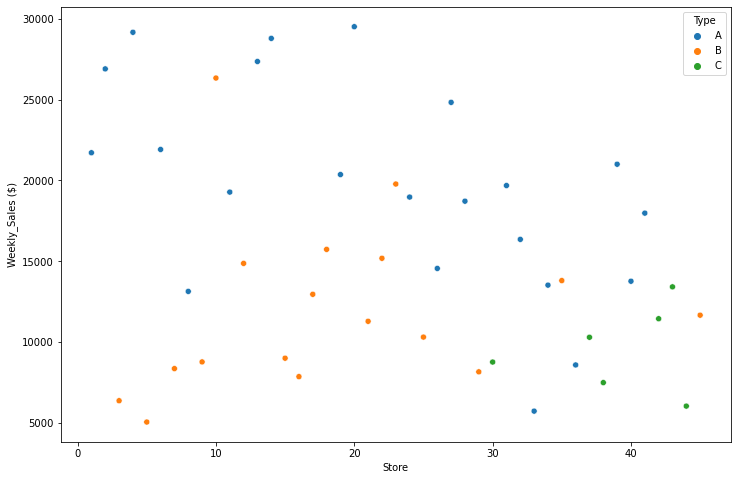

In [39]:
#plot mean weekly_sales for each store and colormap it based on types of the store
plt.subplots(figsize=(12, 8))
sns.scatterplot(x='Store', y='Weekly_Sales', hue='Type', data=Weekly_sales_store_type)
plt.ylabel('Weekly_Sales ($)')
plt.xlabel('Store');

there seem to be a trend, stores of type A have highest weekly sales, stores of type C have lowest weekly sales

In [46]:
#merge stores df with weekly_sales df
Weekly_sales_type=pd.merge(Weekly_sales,stores, how='left', on='Store')
Weekly_sales_type.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315


Text(0.5, 0, 'Store')

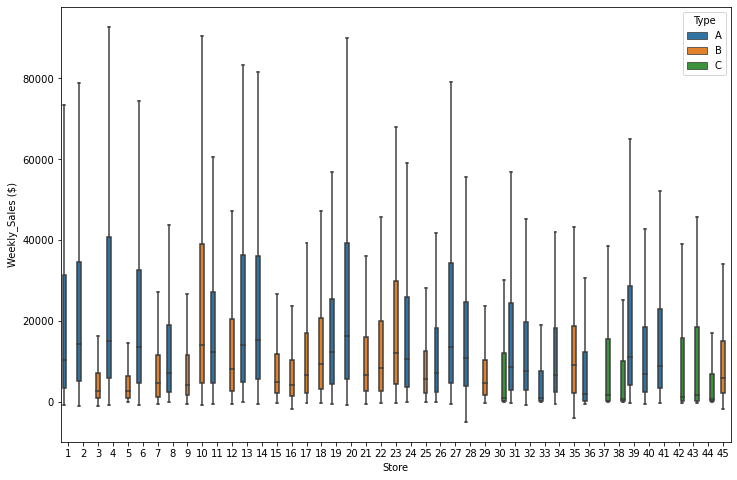

In [47]:
#plot weekly sales distribution for each store, comparing between different store types
plt.subplots(figsize=(12, 8))
sns.boxplot(x='Store', y='Weekly_Sales', hue='Type', showfliers=False, data=Weekly_sales_type)
plt.ylabel('Weekly_Sales ($)')
plt.xlabel('Store')

## 2.2.6 weekly sales trend holiday vs non-holiday 

Text(0.5, 0, 'Store')

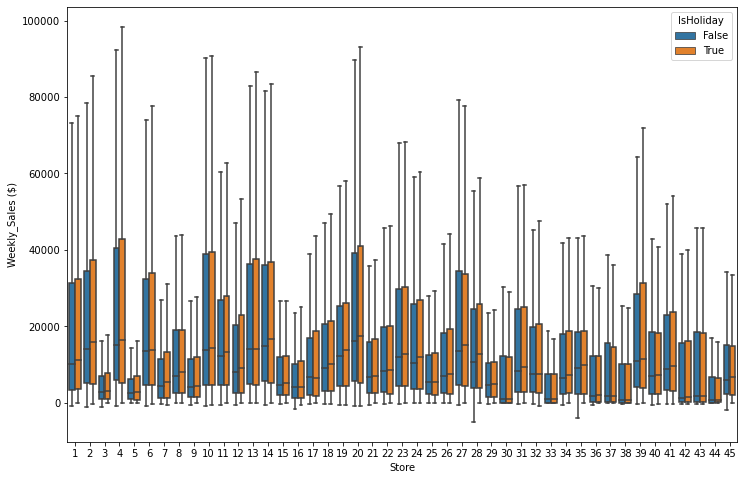

In [42]:
#plot weekly sales distribution for each store, comparing holiday with non-holidays
plt.subplots(figsize=(12, 8))
sns.boxplot(x='Store', y='Weekly_Sales', hue='IsHoliday', showfliers=False, data=Weekly_sales)
plt.ylabel('Weekly_Sales ($)')
plt.xlabel('Store')
#plt.yscale('log')
#plt.ylim(0,30000)



for majority stores, median value of weekly sales on holidays is slightly higher than that on non-holidays. Store 13, 16,25,32,37 are very close. store 17 has opposite trend, non-holidays are higher than holidays

Text(0.5, 0, 'Dept')

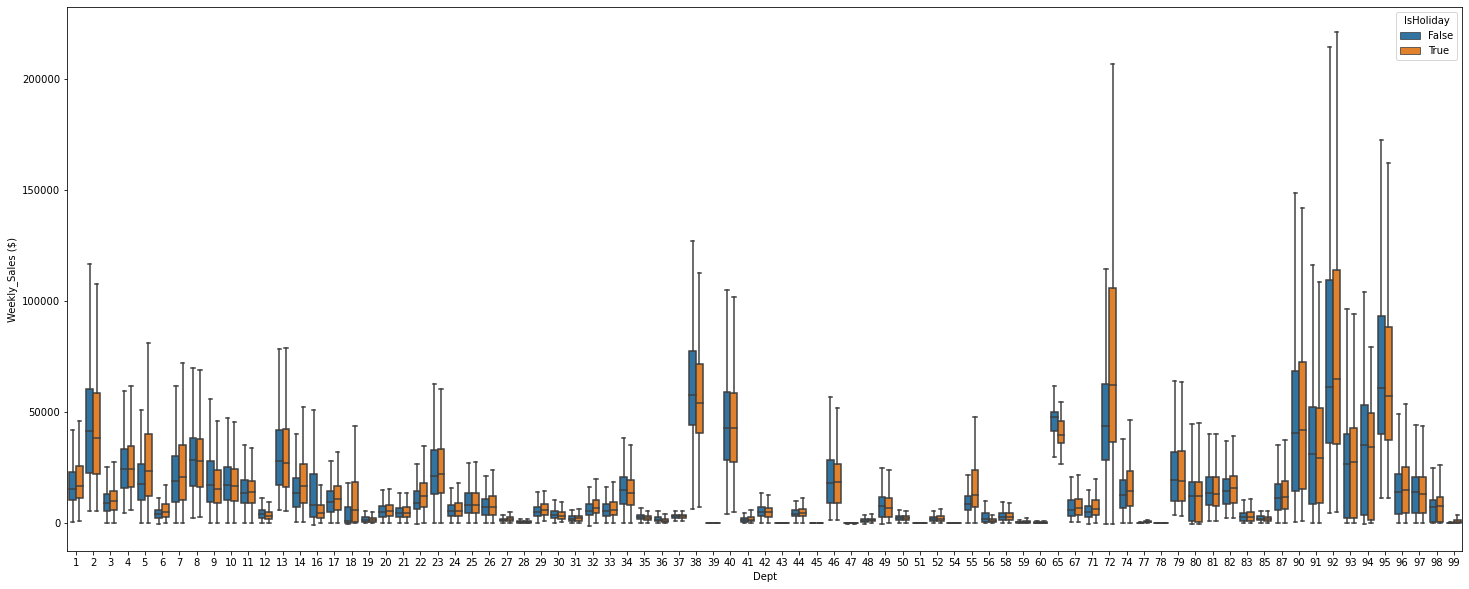

In [44]:
#plot weekly sales distribution for each dept, comparing holiday with non-holidays
plt.subplots(figsize=(25, 10))
sns.boxplot(x='Dept', y='Weekly_Sales', hue='IsHoliday', showfliers=False,data=Weekly_sales)
plt.ylabel('Weekly_Sales ($)')
plt.xlabel('Dept')
#plt.yscale('log')
#plt.ylim(1000,100000)

for different dept, there is no clear trend of higher weekly sales on holiday

## 2.3 numerical variables

In [48]:
features.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,8190.0,23.000000,12.987966,1.000,12.000000,23.000000,34.000000,45.000000
Temperature,8190.0,59.356198,18.678607,-7.290,45.902500,60.710000,73.880000,101.950000
Fuel_Price,8190.0,3.405992,0.431337,2.472,3.041000,3.513000,3.743000,4.468000
MarkDown1,4032.0,7032.371786,9262.747448,-2781.450,1577.532500,4743.580000,8923.310000,103184.980000
MarkDown2,2921.0,3384.176594,8793.583016,-265.760,68.880000,364.570000,2153.350000,104519.540000
MarkDown3,3613.0,1760.100180,11276.462208,-179.260,6.600000,36.260000,163.150000,149483.310000
MarkDown4,3464.0,3292.935886,6792.329861,0.220,304.687500,1176.425000,3310.007500,67474.850000
MarkDown5,4050.0,4132.216422,13086.690278,-185.170,1440.827500,2727.135000,4832.555000,771448.100000
CPI,7605.0,172.460809,39.738346,126.064,132.364839,182.764003,213.932412,228.976456
Unemployment,7605.0,7.826821,1.877259,3.684,6.634000,7.806000,8.567000,14.313000
